# Gentrification Degree Index (GDI) for Paris, 2013–2021

**Scope:** Clean, minimal, reproducible GDI for Paris quartiers (Habitation only), 2013–2017–2021.

**Data sources:**
- `paris_merged_2013.parquet`, `paris_merged_2017.parquet`, `paris_merged_2021.parquet`: Neighborhood-level indicators
- `paris_quartiers.geojson`: Spatial geometries with type_quartier classification

**Six indicators** (pooled z-scores, equal weights):
- median_uc (+), prix_m2_median (+), pct_cadres (+), pct_ouvriers (−), pct_bac_sup (+), pct_25_39 (+)

**Spatial scope:** Analysis on 71 Habitation quartiers. Activité and Divers shown as hatched background on maps only.

## 1. Imports and Setup

In [107]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from libpysal.weights import Queen
from esda.moran import Moran, Moran_Local

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 5)

DATA_DIR = '../datasets'
GEO_FILE = f'{DATA_DIR}/quartiers_paris.geojson'

os.makedirs('./_artifacts/figures', exist_ok=True)
print('Setup complete.')

Setup complete.


## 2. Load Data and Filter to Habitation Quartiers

In [108]:
# Load three waves
files = ['paris_merged_2013.parquet', 'paris_merged_2017.parquet', 'paris_merged_2021.parquet']
dfs = []
for f in files:
    df_temp = pd.read_parquet(f'{DATA_DIR}/{f}')
    df_temp.columns = df_temp.columns.str.lower()
    year = int(f.split('_')[-1].replace('.parquet', ''))
    df_temp['annee'] = year
    dfs.append(df_temp)
    print(f'Loaded {f}: {len(df_temp)} rows')

df = pd.concat(dfs, ignore_index=True)

# Filter to Habitation only
df = df[df['type_neighborhood'].eq('Habitation')].copy()
print(f'\nFiltered to Habitation: {len(df)} rows')
print(f'Quartiers per year: {df.groupby("annee")["neighborhood"].nunique().to_dict()}')

Loaded paris_merged_2013.parquet: 71 rows
Loaded paris_merged_2017.parquet: 71 rows
Loaded paris_merged_2021.parquet: 71 rows

Filtered to Habitation: 213 rows
Quartiers per year: {2013: 71, 2017: 71, 2021: 71}


## 3. Derive Indicators and Year De-Trend

In [109]:
# Rename key columns for clarity
df = df.rename(columns={'neighborhood': 'quartier'})

# Derive pct_bac_sup
df['pct_bac_sup'] = 100 * df['pop_bac_sup'] / df['pop_15plus']

# Year de-trend for income and price
for v in ['median_uc', 'prix_m2_median']:
    df[f'{v}_detr'] = df[v] - df.groupby('annee')[v].transform('median')
    print(f'{v}_detr medians by year (should be near zero):')
    print(df.groupby('annee')[f'{v}_detr'].median())

print('\nDerived indicators created and de-trended.')

median_uc_detr medians by year (should be near zero):
annee
2013    0.0
2017    0.0
2021    0.0
Name: median_uc_detr, dtype: float64
prix_m2_median_detr medians by year (should be near zero):
annee
2013    0.0
2017    0.0
2021    0.0
Name: prix_m2_median_detr, dtype: float64

Derived indicators created and de-trended.


## 4. Pooled Winsorization and Standardization

In [110]:
# Winsor function
def winsor(s, p=0.025):
    return s.clip(s.quantile(p), s.quantile(1 - p))

# Six indicators with polarity
spec = [
    ('median_uc_detr', +1),
    ('prix_m2_median_detr', +1),
    ('pct_cadres', +1),
    ('pct_ouvriers', -1),
    ('pct_bac_sup', +1),
    ('pct_25_39', +1),
]

for col, sign in spec:
    x = winsor(df[col].astype(float))
    mu, sd = x.mean(), x.std(ddof=0)
    if sd == 0:
        df[f'z_{col}'] = 0.0
    else:
        df[f'z_{col}'] = sign * (x - mu) / sd
    print(f'{col:25s} | sign={sign:+2d} | μ={mu:10.2f}, σ={sd:8.2f}')

print('\nPooled z-scores computed.')

median_uc_detr            | sign=+1 | μ=    637.74, σ= 7128.72
prix_m2_median_detr       | sign=+1 | μ=    213.63, σ= 1644.07
pct_cadres                | sign=+1 | μ=     30.87, σ=    5.27
pct_ouvriers              | sign=-1 | μ=      3.86, σ=    1.76
pct_bac_sup               | sign=+1 | μ=     53.71, σ=    7.40
pct_25_39                 | sign=+1 | μ=     25.99, σ=    4.70

Pooled z-scores computed.


## 5. Composite GDI (Equal Weights, 0–100 Rescale)

In [111]:
zcols = [f'z_{c}' for c, _ in spec]
df['GDI_raw'] = df[zcols].mean(axis=1)

# Min-max rescale to [0, 100]
gmin, gmax = df['GDI_raw'].min(), df['GDI_raw'].max()
df['GDI'] = 100 * (df['GDI_raw'] - gmin) / (gmax - gmin)

print(f'GDI range: [{df["GDI"].min():.1f}, {df["GDI"].max():.1f}]')
print(f'Mean: {df["GDI"].mean():.1f}, Median: {df["GDI"].median():.1f}')

GDI range: [0.0, 100.0]
Mean: 65.9, Median: 73.5


In [112]:
# Save tidy panel
keep_cols = ['quartier', 'annee', 'median_uc', 'prix_m2_median', 'pct_cadres', 'pct_ouvriers', 
             'pct_bac_sup', 'pct_25_39', 'GDI']
df[keep_cols].to_parquet('./_artifacts/GDI_panel.parquet', index=False)
print('Saved GDI_panel.parquet')

Saved GDI_panel.parquet


## 6. Temporal Change and Simple 3-Bin Classification

In [113]:
# Pivot to wide
wide = df.pivot_table(index='quartier', columns='annee', values='GDI')
wide = wide.rename(columns={2013: 'GDI_2013', 2017: 'GDI_2017', 2021: 'GDI_2021'})

# Compute changes
wide['d13_17'] = wide['GDI_2017'] - wide['GDI_2013']
wide['d17_21'] = wide['GDI_2021'] - wide['GDI_2017']
wide['d13_21'] = wide['GDI_2021'] - wide['GDI_2013']

# Simple 3-bin trajectory on d13_21
q25, q75 = wide['d13_21'].quantile([0.25, 0.75])
def lab(x):
    if x >= q75:
        return 'Accelerating/strong increase'
    if x <= q25:
        return 'Declining/weak'
    return 'Moderate/stable'

wide['trajectory'] = wide['d13_21'].apply(lab)

print(f'Change thresholds: Q25={q25:.2f}, Q75={q75:.2f}')
print('\nTrajectory distribution:')
print(wide['trajectory'].value_counts())

Change thresholds: Q25=1.83, Q75=11.29

Trajectory distribution:
trajectory
Moderate/stable                 35
Declining/weak                  18
Accelerating/strong increase    18
Name: count, dtype: int64


In [114]:
# Save wide table
wide.reset_index().to_parquet('./_artifacts/GDI_wide.parquet', index=False)
print('Saved GDI_wide.parquet')

Saved GDI_wide.parquet


## 7. Spatial Joins: Habitation, Activité, Divers

In [115]:
# Load geometries
gq = gpd.read_file(GEO_FILE)
g_hab = gq[gq['type_quartier'].eq('Habitation')].copy()
g_act = gq[gq['type_quartier'].eq('Activité')].copy()
g_div = gq[gq['type_quartier'].eq('Divers')].copy()

print(f'Habitation: {len(g_hab)}, Activité: {len(g_act)}, Divers: {len(g_div)}')

# Merge Habitation with wide data
g2021 = g_hab.merge(wide[['GDI_2021', 'd13_21']], left_on='quartier', right_index=True, how='inner').dropna()
print(f'\nMerged Habitation for 2021: {len(g2021)} quartiers')

Habitation: 71, Activité: 9, Divers: 14

Merged Habitation for 2021: 71 quartiers


## 8. Spatial Autocorrelation (Habitation Only)

In [116]:
# Queen weights on Habitation
W = Queen.from_dataframe(g2021)
W.transform = 'r'

print(f'Spatial weights: {W.n} units, avg neighbors: {W.mean_neighbors:.2f}')

# Global Moran's I
m_level = Moran(g2021['GDI_2021'].to_numpy(), W)
m_change = Moran(g2021['d13_21'].to_numpy(), W)

print(f'\nGlobal Moran I (GDI 2021): I={m_level.I:.4f}, p={m_level.p_sim:.4f}')
print(f'Global Moran I (Δ 2013→2021): I={m_change.I:.4f}, p={m_change.p_sim:.4f}')

('WARNING: ', 36, ' is an island (no neighbors)')
Spatial weights: 71 units, avg neighbors: 4.62



Global Moran I (GDI 2021): I=0.5900, p=0.0010
Global Moran I (Δ 2013→2021): I=0.4947, p=0.0010


/tmp/ipykernel_26702/1906951740.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  W = Queen.from_dataframe(g2021)
/usr/local/python/3.12.1/lib/python3.12/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There is 1 island with id: 36.
  W.__init__(self, neighbors, ids=ids, **kw)


In [117]:
# Local LISA
lisa = Moran_Local(g2021['GDI_2021'].to_numpy(), W)
g2021['lisa_sig'] = lisa.p_sim < 0.05
labmap = {1: 'High-High', 2: 'Low-High', 3: 'Low-Low', 4: 'High-Low'}
g2021['lisa_label'] = np.where(g2021['lisa_sig'], pd.Series(lisa.q, index=g2021.index).map(labmap), 'Not significant')

print('\nLISA clusters (GDI 2021):')
print(g2021['lisa_label'].value_counts())


LISA clusters (GDI 2021):
lisa_label
Not significant    45
High-High          17
Low-Low             7
High-Low            2
Name: count, dtype: int64


/usr/local/python/3.12.1/lib/python3.12/site-packages/esda/moran.py:1354: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


## 9. Minimal Visuals

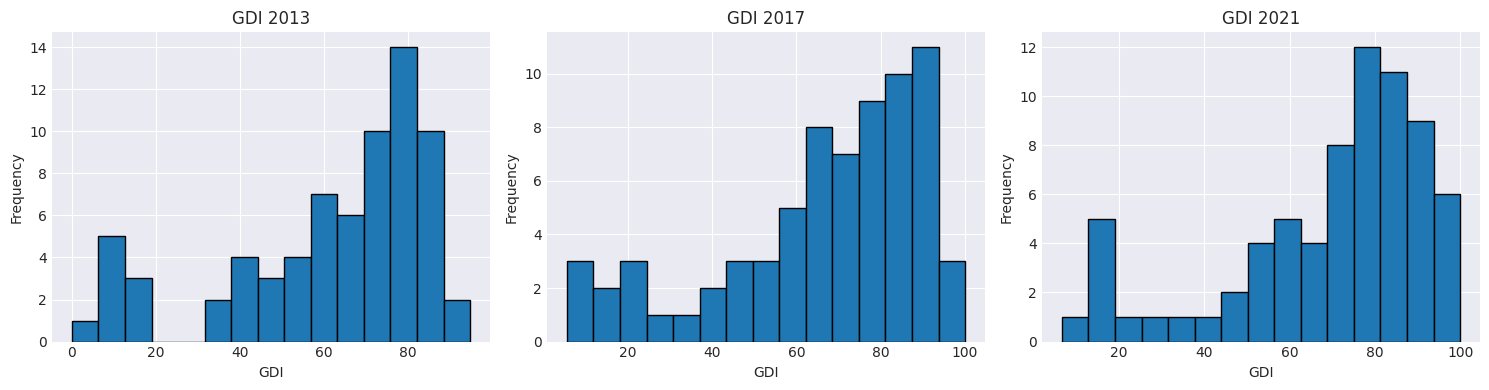

Saved gdi_histograms.png


In [118]:
# Histograms of GDI by year (3 panels)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, yr in zip(axes, [2013, 2017, 2021]):
    data = df[df['annee'].eq(yr)]['GDI']
    ax.hist(data, bins=15, edgecolor='black')
    ax.set_title(f'GDI {yr}')
    ax.set_xlabel('GDI')
    ax.set_ylabel('Frequency')
plt.tight_layout()
plt.savefig('./_artifacts/figures/gdi_histograms.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved gdi_histograms.png')

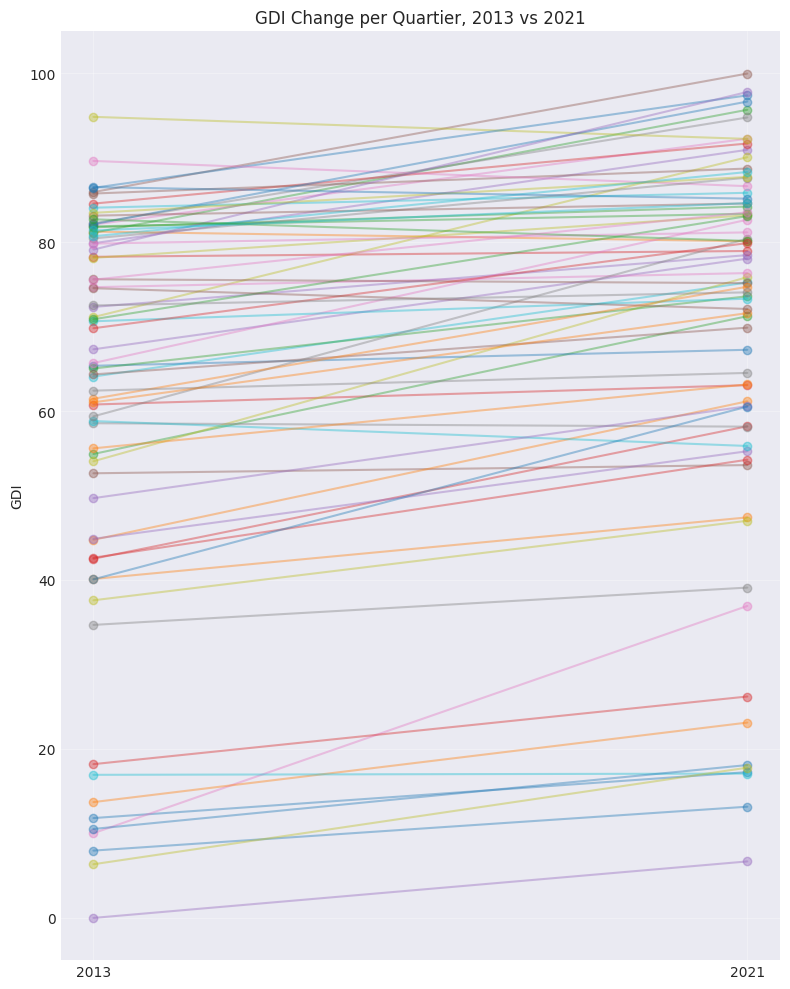

Saved gdi_slopegraph.png


In [119]:
# Slopegraph: GDI 2013 vs 2021
fig, ax = plt.subplots(1, 1, figsize=(8, 10))
for idx, row in wide.iterrows():
    ax.plot([2013, 2021], [row['GDI_2013'], row['GDI_2021']], marker='o', alpha=0.4)
ax.set_xticks([2013, 2021])
ax.set_ylabel('GDI')
ax.set_title('GDI Change per Quartier, 2013 vs 2021')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./_artifacts/figures/gdi_slopegraph.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved gdi_slopegraph.png')

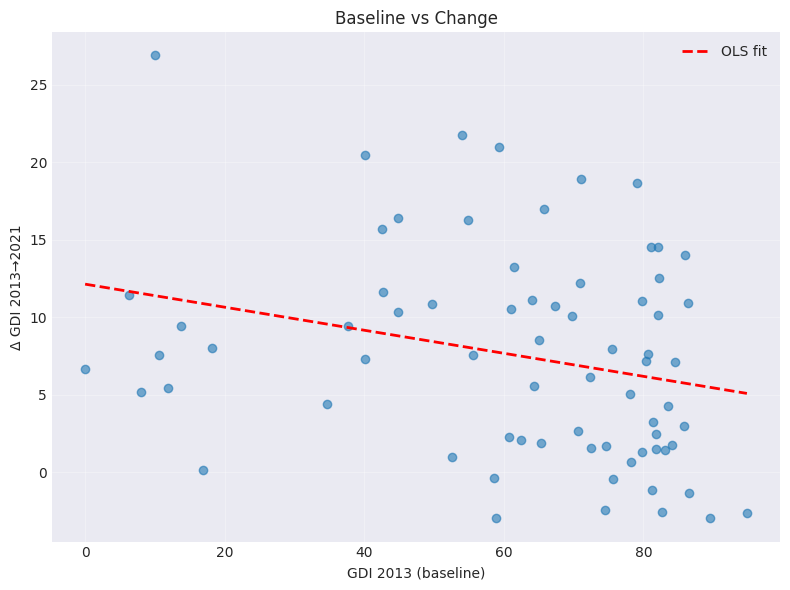

Saved baseline_vs_change.png


In [120]:
# Scatter: Baseline vs change
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(wide['GDI_2013'], wide['d13_21'], alpha=0.6)
# OLS line
slope, intercept, _, _, _ = linregress(wide['GDI_2013'], wide['d13_21'])
x_range = np.linspace(wide['GDI_2013'].min(), wide['GDI_2013'].max(), 100)
ax.plot(x_range, intercept + slope * x_range, 'r--', linewidth=2, label='OLS fit')
ax.set_xlabel('GDI 2013 (baseline)')
ax.set_ylabel('Δ GDI 2013→2021')
ax.set_title('Baseline vs Change')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./_artifacts/figures/baseline_vs_change.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved baseline_vs_change.png')

### Maps with Hatched Overlays

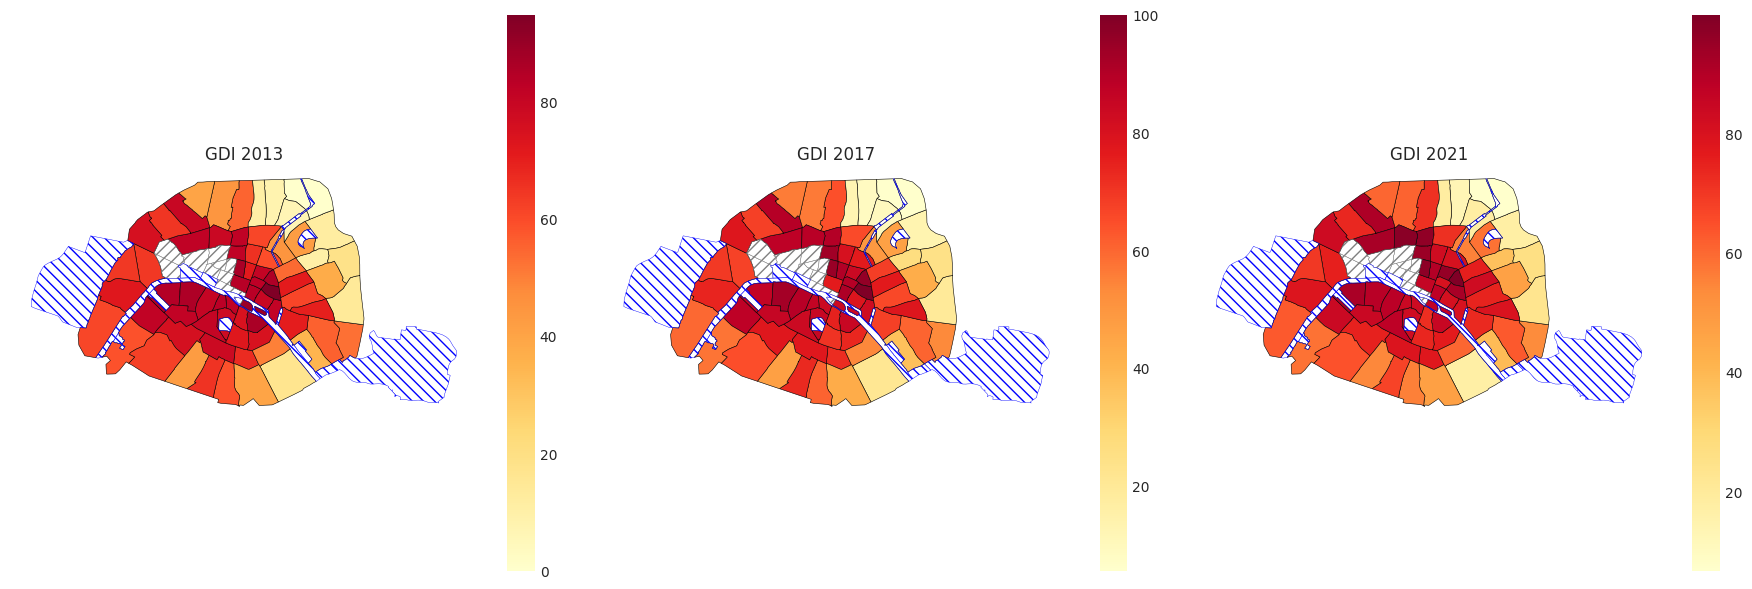

Saved gdi_maps_by_year.png


In [121]:
# GDI 2013, 2017, 2021 (Habitation filled, Activité & Divers hatched)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for ax, yr in zip(axes, [2013, 2017, 2021]):
    layer = g_hab.merge(df[df['annee'].eq(yr)][['quartier', 'GDI']], on='quartier', how='inner')
    layer.plot(column='GDI', legend=True, ax=ax, edgecolor='black', linewidth=0.4, cmap='YlOrRd')
    g_act.plot(ax=ax, facecolor='none', edgecolor='gray', hatch='///', linewidth=0.3)
    g_div.plot(ax=ax, facecolor='none', edgecolor='blue', hatch='\\\\\\', linewidth=0.3)
    ax.set_title(f'GDI {yr}')
    ax.axis('off')
plt.tight_layout()
plt.savefig('./_artifacts/figures/gdi_maps_by_year.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved gdi_maps_by_year.png')

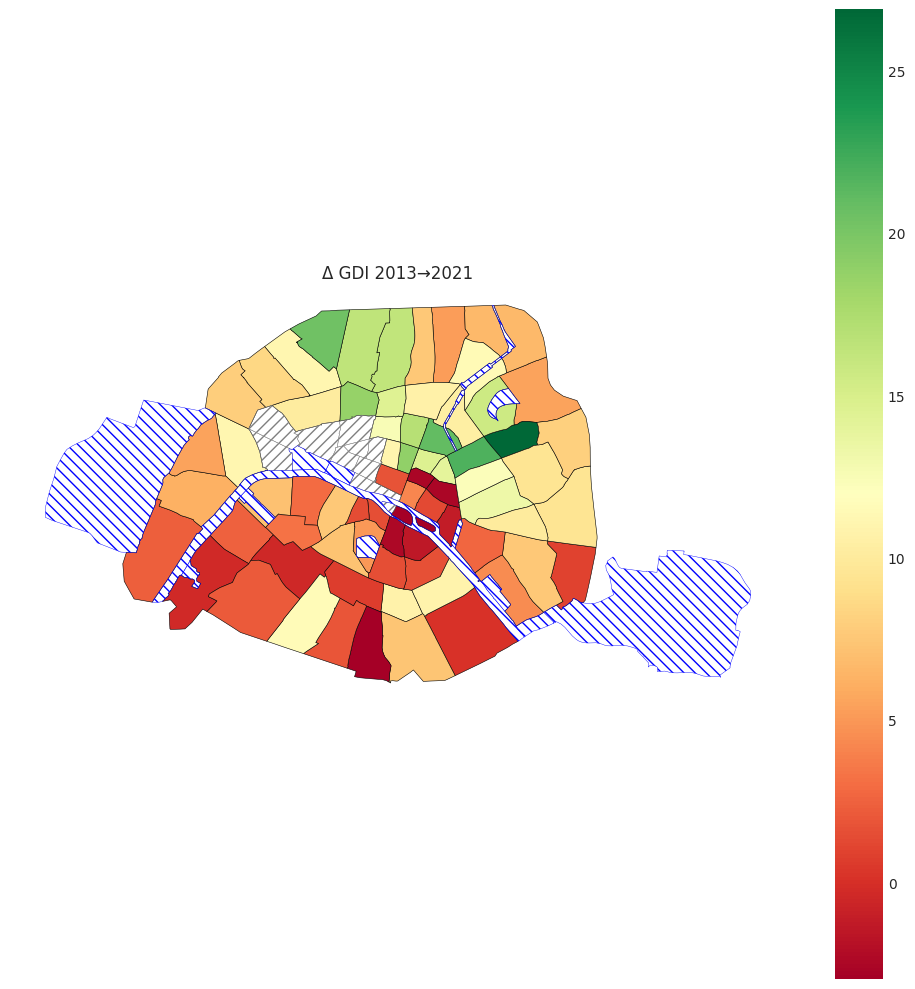

Saved gdi_change_map.png


In [122]:
# Δ 2013→2021 map
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
layer = g_hab.merge(wide[['d13_21']], left_on='quartier', right_index=True, how='inner')
layer.plot(column='d13_21', legend=True, ax=ax, edgecolor='black', linewidth=0.4, cmap='RdYlGn')
g_act.plot(ax=ax, facecolor='none', edgecolor='gray', hatch='///', linewidth=0.3)
g_div.plot(ax=ax, facecolor='none', edgecolor='blue', hatch='\\\\\\', linewidth=0.3)
ax.set_title('Δ GDI 2013→2021')
ax.axis('off')
plt.tight_layout()
plt.savefig('./_artifacts/figures/gdi_change_map.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved gdi_change_map.png')

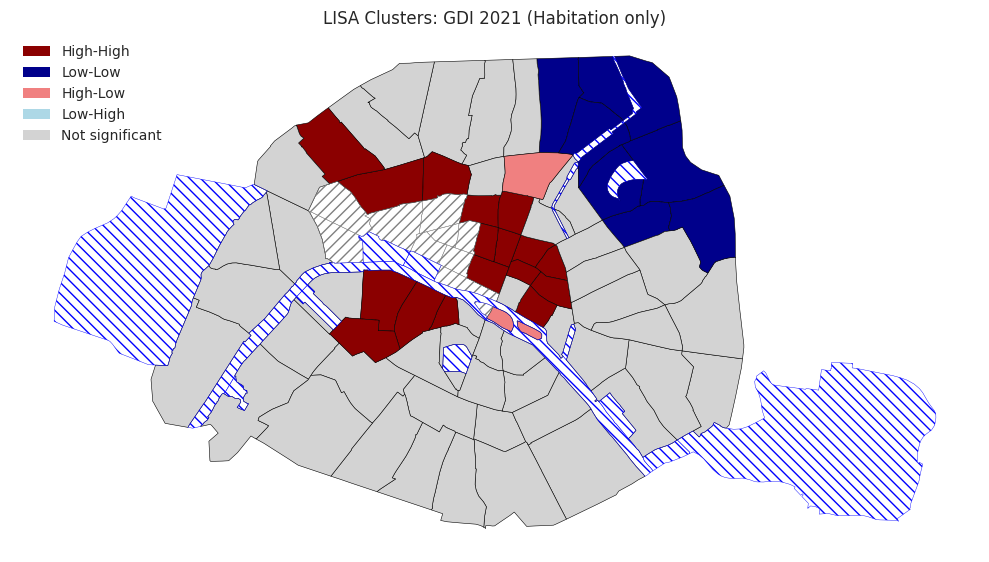

Saved lisa_clusters_2021.png


In [123]:
# LISA cluster map for 2021 (Habitation only)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
cluster_colors = {
    'High-High': 'darkred',
    'Low-Low': 'darkblue',
    'High-Low': 'lightcoral',
    'Low-High': 'lightblue',
    'Not significant': 'lightgrey'
}
g2021['color'] = g2021['lisa_label'].map(cluster_colors)
g2021.plot(color=g2021['color'], ax=ax, edgecolor='black', linewidth=0.4)
g_act.plot(ax=ax, facecolor='none', edgecolor='gray', hatch='///', linewidth=0.3)
g_div.plot(ax=ax, facecolor='none', edgecolor='blue', hatch='\\\\\\', linewidth=0.3)

from matplotlib.patches import Patch
legend = [Patch(facecolor=color, label=label) for label, color in cluster_colors.items()]
ax.legend(handles=legend, loc='upper left')
ax.set_title('LISA Clusters: GDI 2021 (Habitation only)')
ax.axis('off')
plt.tight_layout()
plt.savefig('./_artifacts/figures/lisa_clusters_2021.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved lisa_clusters_2021.png')

## 10. QA and Assertions

In [124]:
# Assert same set of 71 Habitation quartiers in all years
assert set(df.loc[df['annee'].eq(2013), 'quartier']) == \
       set(df.loc[df['annee'].eq(2017), 'quartier']) == \
       set(df.loc[df['annee'].eq(2021), 'quartier']), \
       'Quartier sets differ across years!'

print('✓ Same 71 Habitation quartiers in all years')

# Print row counts per year
print('\nRow counts per year:')
print(df.groupby('annee')['quartier'].nunique())

# GDI range
print(f'\nGDI range: [{df["GDI"].min():.1f}, {df["GDI"].max():.1f}]')

# Top/bottom 5 in 2021
print('\nTop 5 quartiers in 2021:')
print(df[df['annee'].eq(2021)].nlargest(5, 'GDI')[['quartier', 'GDI']].to_string(index=False))
print('\nBottom 5 quartiers in 2021:')
print(df[df['annee'].eq(2021)].nsmallest(5, 'GDI')[['quartier', 'GDI']].to_string(index=False))

✓ Same 71 Habitation quartiers in all years

Row counts per year:
annee
2013    71
2017    71
2021    71
Name: quartier, dtype: int64

GDI range: [0.0, 100.0]

Top 5 quartiers in 2021:
       quartier      GDI
 Enfants Rouges 99.94589
  Saint-Georges 97.76682
           Mail 97.36539
   Rochechouart 96.63004
Arts et Métiers 95.65838

Bottom 5 quartiers in 2021:
       quartier      GDI
Pont de Flandre  6.68786
       Chapelle 13.16534
           Gare 17.08260
       Amérique 17.25546
       Villette 17.78667


In [125]:
# Check de-trended medians are near zero
for v in ['median_uc_detr', 'prix_m2_median_detr']:
    by_year = df.groupby('annee')[v].median()
    print(f'\n{v} medians by year:')
    print(by_year)
    assert by_year.abs().max() < 1.0, f'{v} medians not near zero!'

print('\n✓ De-trended medians near zero')


median_uc_detr medians by year:
annee
2013    0.0
2017    0.0
2021    0.0
Name: median_uc_detr, dtype: float64

prix_m2_median_detr medians by year:
annee
2013    0.0
2017    0.0
2021    0.0
Name: prix_m2_median_detr, dtype: float64

✓ De-trended medians near zero


In [127]:
# Polarity check: After applying negative sign to pct_ouvriers, all indicators should be positively correlated
# (all z-scores now point in same direction: higher = more gentrified)
corr_check = df[df['annee'].eq(2021)][['z_pct_ouvriers', 'z_pct_cadres', 'z_pct_bac_sup']].corr()
print('\nCorrelation matrix (2021, z-scores):')  
print(corr_check)

assert corr_check.loc['z_pct_ouvriers', 'z_pct_cadres'] > 0, 'z_pct_ouvriers not positively correlated with z_pct_cadres after polarity applied'
assert corr_check.loc['z_pct_ouvriers', 'z_pct_bac_sup'] > 0, 'z_pct_ouvriers not positively correlated with z_pct_bac_sup after polarity applied'

print('\n✓ Polarity checks passed: All z-scores align with gentrification direction')


Correlation matrix (2021, z-scores):
                z_pct_ouvriers  z_pct_cadres  z_pct_bac_sup
z_pct_ouvriers         1.00000       0.60915        0.82657
z_pct_cadres           0.60915       1.00000        0.83071
z_pct_bac_sup          0.82657       0.83071        1.00000

✓ Polarity checks passed: All z-scores align with gentrification direction


## 11. Summary and Key Findings

**Main findings:**

1. **GDI increased citywide from 2013 to 2021** with right-shifting distributions across all three waves.

2. **Spatial clustering is significant** (Global Moran's I, p < 0.05). Acceleration is concentrated in specific Habitation clusters identified by LISA; non-residential areas (Activité and Divers) are shown hatched for context but excluded from inference.